<a href="https://colab.research.google.com/github/ashaoluayanfe/data_analysis_projects/blob/main/Ames_regression_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict Sales Prices and Practice Feature Engineering, RFs, and Gradient Boosting of Ames Housing Dataset**

## **1. Problem Definition**
> Predicting the final price of houses in Ames, Iowa giving some features

## **2. Data**
> The data is downloaded from Kaggle for the House Prices - Advanced Regression Techniques competition:


> https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
* train.csv - the training set
* test.csv - the test set

## **3. Evaluation Metric**
> Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

## **4. Features**
> Kaggle provides the features in a text format which can be viewed on GoogleSheets:    
https://docs.google.com/document/d/1EyXUMDX1WxLD8W7pqlqM5KfB04WNOXichwJBt7DsbXs/edit?usp=sharing

## **5. Modelling**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# import the training set
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_dataset/Ames_housing_project/ames_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df.isna().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64

### **Converting String into Categoricals**

> One way to convert data into numbers is by converting them into pandas categories. 
https://pandas.pydata.org/docs/reference/api/pandas.api.types.pandas_dtype.html

In [ ]:
# find the labels that contain strings
for label, content in df.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [ ]:
# Turning all strings value into category values
for label, content in df.items():
  if pd.api.types.is_string_dtype(content):
    df[label]=content.astype('category').cat.as_ordered()

### **Filling Missing Numerical Values**

In [ ]:
# Check for which numeric columns have null values
for label, content in df.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

LotFrontage
MasVnrArea
GarageYrBlt


In [ ]:
# Fill numeric rows with median
for label, content in df.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # Add binary column which tells if the data is missing or not
      df[label + '_is_missing']= pd.isnull(content)
      # Fill missing numeric values with median
      df[label] = content.fillna(content.median()) 

### **Turn Categoricals into Numbers and Fill the Missing Values**

In [ ]:
# Identify the categorical columns
for label, content in df.items():
  if not pd.api.types.is_numeric_dtype(content):
    print(label)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [ ]:
# Turn all Categorical Variables to Numbers and Fill Missing Values
for label, content in df.items():
  if not pd.api.types.is_numeric_dtype(content):
    # Add binary column to indicate whether sample has missing values
    df[label + '_is_missing'] = pd.isnull(content)
    # Turn categories into numbers and add + 1
    df[label]= pd.Categorical(content).codes + 1

In [ ]:
df.isna().sum()

Id                          0
MSSubClass                  0
MSZoning                    0
LotFrontage                 0
LotArea                     0
                           ..
PoolQC_is_missing           0
Fence_is_missing            0
MiscFeature_is_missing      0
SaleType_is_missing         0
SaleCondition_is_missing    0
Length: 127, dtype: int64

### **Split Data into Train and Test Set**

In [ ]:
from sklearn.model_selection import train_test_split
X, y= df.drop('SalePrice', axis=1),  df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 126), (292, 126), (1168,), (292,))

### **Building an Evaluation Function**

In [ ]:
# Create evaluation function  (the competiton uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(true, preds):
  '''''
    calculates root mean squared log error between predictions and true labels
  '''''
  return np.sqrt(mean_squared_log_error(true, preds))

# Create function to evaluate model on a few different  levels
def show_scores(model):
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)
  scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
            'Test MAE': mean_absolute_error(y_test, test_preds),
            'Training RMSLE': rmsle(y_train, train_preds),
            'Test RMSLE': rmsle(y_test, test_preds),
            'Training R^2': r2_score(y_train, train_preds),
            'Test R^2': r2_score(y_test, test_preds)}
  return scores

### **Testing the Models**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
show_scores(rf)

{'Test MAE': 17642.673424657532,
 'Test RMSLE': 0.15363037621101558,
 'Test R^2': 0.8931795347402904,
 'Training MAE': 6572.157294520549,
 'Training RMSLE': 0.0594979568798942,
 'Training R^2': 0.9803002849898841}

### Using Catboost

In [ ]:
! pip install catboost

In [ ]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor(random_seed= 42)
cb.fit(X_train, y_train)

Learning rate set to 0.04196
0:	learn: 75088.5530954	total: 58.2ms	remaining: 58.2s
1:	learn: 73164.5940568	total: 64.4ms	remaining: 32.1s
2:	learn: 71278.1098229	total: 69.9ms	remaining: 23.2s
3:	learn: 69601.6162784	total: 75.5ms	remaining: 18.8s
4:	learn: 67706.7980694	total: 80.9ms	remaining: 16.1s
5:	learn: 66155.2037558	total: 86.7ms	remaining: 14.4s
6:	learn: 64638.2522592	total: 92.3ms	remaining: 13.1s
7:	learn: 63009.0070939	total: 97.9ms	remaining: 12.1s
8:	learn: 61686.4817243	total: 103ms	remaining: 11.4s
9:	learn: 60353.6962893	total: 109ms	remaining: 10.8s
10:	learn: 59030.6440277	total: 115ms	remaining: 10.3s
11:	learn: 57692.1008270	total: 121ms	remaining: 9.95s
12:	learn: 56518.6919229	total: 127ms	remaining: 9.61s
13:	learn: 55275.6403547	total: 132ms	remaining: 9.32s
14:	learn: 54176.7845182	total: 138ms	remaining: 9.07s
15:	learn: 52977.5426349	total: 144ms	remaining: 8.85s
16:	learn: 51841.4325508	total: 150ms	remaining: 8.68s
17:	learn: 50804.7883817	total: 156ms	

In [ ]:
show_scores(cb)

{'Test MAE': 15779.041214473355,
 'Test RMSLE': 0.13535631449763183,
 'Test R^2': 0.9066982736572659,
 'Training MAE': 3919.63766883402,
 'Training RMSLE': 0.03523784991713482,
 'Training R^2': 0.9955671598659175}

### **Make Predictions on Kaggle Test Data**

In [ ]:
# Import Test Set
Ames_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_dataset/Ames_housing_project/ames_test.csv')
Ames_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#### **Preprocessing the Data (Getting the Test Dataset in the Same Format as Training Dataset)**

In [ ]:
Ames_test.isna().sum().sort_values(ascending=False)

PoolQC         1456
MiscFeature    1408
Alley          1352
Fence          1169
FireplaceQu     730
               ... 
Electrical        0
CentralAir        0
HeatingQC         0
Foundation        0
Id                0
Length: 80, dtype: int64

In [ ]:
# Check the labels that contain strings
for label, content  in Ames_test.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [ ]:
# Turn all strings into categoricals
for label, content in Ames_test.items():
  if pd.api.types.is_string_dtype(content):
    Ames_test[label]= content.astype('category').cat.as_ordered()

In [ ]:
Ames_test['SaleType'].dtype

CategoricalDtype(categories=['COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth',
                  'WD'],
                 ordered=True)

In [ ]:
# Filling with missing values
Ames_test.isna().sum().sort_values(ascending=False)

PoolQC         1456
MiscFeature    1408
Alley          1352
Fence          1169
FireplaceQu     730
               ... 
Electrical        0
CentralAir        0
HeatingQC         0
Foundation        0
Id                0
Length: 80, dtype: int64

In [ ]:
# Filling Numerical Missing values
for label, content in Ames_test.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # Add binary column which indicate if the data is missing or not
      Ames_test[label + '_is_missing']=pd.isnull(content)
      # Fill missing numeric values with median
      Ames_test[label] = content.fillna(content.median())
      

In [ ]:
# Filling categorical missing values
for label, content in Ames_test.items():
  if not pd.api.types.is_numeric_dtype(content):
    # Add binary column to indicate whether sample had missing values
    Ames_test[label + '_is_missing'] = pd.isnull(content)
    # Turn categorical into numbers and add + 1
    Ames_test[label] = pd.Categorical(content).codes + 1


In [ ]:
Ames_test.isna().sum()

Id                          0
MSSubClass                  0
MSZoning                    0
LotFrontage                 0
LotArea                     0
                           ..
PoolQC_is_missing           0
Fence_is_missing            0
MiscFeature_is_missing      0
SaleType_is_missing         0
SaleCondition_is_missing    0
Length: 134, dtype: int64

In [ ]:
# Checking matches in X_train and the test columns
set(Ames_test.columns) - set(X_train.columns)

{'BsmtFinSF1_is_missing',
 'BsmtFinSF2_is_missing',
 'BsmtFullBath_is_missing',
 'BsmtHalfBath_is_missing',
 'BsmtUnfSF_is_missing',
 'GarageArea_is_missing',
 'GarageCars_is_missing',
 'TotalBsmtSF_is_missing'}

In [ ]:
X_train.shape, Ames_test.shape

((1168, 126), (1459, 134))

In [ ]:
Ames_test.drop(['BsmtFinSF1_is_missing', 'BsmtFinSF2_is_missing', 'BsmtFullBath_is_missing', 'BsmtHalfBath_is_missing', 'BsmtUnfSF_is_missing','GarageArea_is_missing', 'GarageCars_is_missing','TotalBsmtSF_is_missing'], axis=1, inplace=True)

In [ ]:
X_train.shape, Ames_test.shape

((1168, 126), (1459, 126))

#### **Make Preductions on Test Data**

In [ ]:
# Make predictions on the test data
test_preds = cb.predict(Ames_test)

In [ ]:
test_preds

array([125027.76342622, 161331.54138123, 188416.29589947, ...,
       160463.09723446, 116866.87476743, 226215.21269001])

#### **Format Predictions as Specified by Kaggle**
> https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

In [ ]:
df_preds = pd.DataFrame()
df_preds['Id'] = Ames_test['Id']
df_preds['SalePrice']= test_preds
df_preds

,Id,SalePrice
0,1461,125027.763426
1,1462,161331.541381
2,1463,188416.295899
3,1464,192812.983496
4,1465,197908.754565
...,...,...
1454,2915,80715.593975
1455,2916,88218.299727
1456,2917,160463.097234
1457,2918,116866.874767


In [ ]:
# Export prediction data
df_preds.to_csv('/content/drive/MyDrive/Colab Notebooks/ml_dataset/Ames_housing_project/Ames_saleprice_prediction.csv', index=False)

#### Feature Importance

In [ ]:
from catboost import Pool
cb.feature_importances_


array([7.52172811e-01, 2.39183301e-01, 6.80667796e-01, 1.10528272e+00,
       3.37841872e+00, 4.33175480e-04, 2.45636238e-02, 3.26185080e-01,
       1.00926903e+00, 0.00000000e+00, 1.33257639e-01, 1.30549736e-01,
       1.80184749e+00, 4.38903669e-01, 1.19129186e-01, 6.23781733e-02,
       9.40890085e-01, 2.22792236e+01, 1.25068956e+00, 2.82725635e+00,
       2.22735263e+00, 3.49178291e-01, 8.36484287e-03, 4.70035324e-01,
       1.05575927e-01, 2.04804832e-01, 4.83727839e-01, 2.28993785e+00,
       1.37213835e-02, 8.81053250e-02, 1.80124901e+00, 1.21075617e-01,
       3.81685246e-01, 2.22438591e-01, 4.50936518e+00, 5.22184345e-03,
       1.71376312e-01, 4.39111286e-01, 4.20756704e+00, 8.66791334e-03,
       4.21705615e-01, 7.38769089e-01, 2.70251503e-02, 4.25990834e+00,
       1.84115179e+00, 6.32097500e-04, 1.37576672e+01, 8.36522461e-01,
       3.43596209e-02, 1.77152781e+00, 3.99943733e-01, 2.99081063e-01,
       4.57674663e-01, 9.94169741e-01, 1.52402795e+00, 3.33064031e-01,
      

In [ ]:
# Helper function for feature importance
def plot_features(columns, importances, n=25):
  df = (pd.DataFrame({'features':columns,
                      'feature_importances': importances})
                      .sort_values('feature_importances', ascending=False)
                      .reset_index(drop=True))
  # Plot the dataframe
  fig, ax= plt.subplots(figsize=(12,18))
  ax.barh(df['features'][:n], df['feature_importances'][:n])
  ax.set_ylabel('Features')
  ax.set_xlabel('Feature importance')
  ax.invert_yaxis()
  

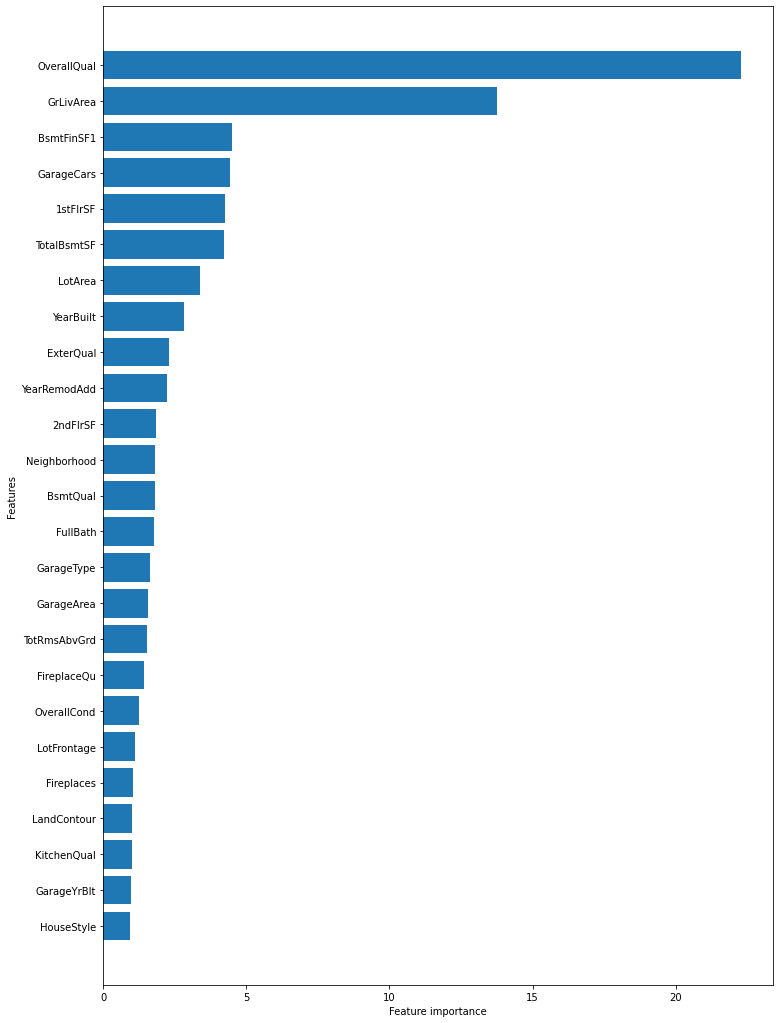

In [ ]:
plot_features(X_train.columns, cb.feature_importances_)